In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import SymLogNorm
import h5py
from tqdm import tqdm

In [20]:
!ls sims.TNG/

L205n1250TNG	 L35n2160TNG	 L75n455TNG	TNG100-3       TNG50-1
L205n1250TNG_DM  L35n2160TNG_DM  L75n455TNG_DM	TNG100-3-Dark  TNG50-1-Dark
L205n2500TNG	 L35n270TNG	 L75n910TNG	TNG300-1       TNG50-2
L205n2500TNG_DM  L35n270TNG_DM	 L75n910TNG_DM	TNG300-1-Dark  TNG50-2-Dark
L205n625TNG	 L35n540TNG	 TNG100-1	TNG300-2       TNG50-3
L205n625TNG_DM	 L35n540TNG_DM	 TNG100-1-Dark	TNG300-2-Dark  TNG50-3-Dark
L35n1080TNG	 L75n1820TNG	 TNG100-2	TNG300-3       TNG50-4
L35n1080TNG_DM	 L75n1820TNG_DM  TNG100-2-Dark	TNG300-3-Dark  TNG50-4-Dark


In [2]:
basePath = 'sims.TNG/TNG100-1/output'
fields = ['SubhaloMass','SubhaloSFRinRad']
snap = 99
# subhalos = il.groupcat.loadSubhalos(basePath,snap,fields=fields)

halo_ID = 239993
tree = il.sublink.loadTree(basePath,snap,halo_ID)
tree_main = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)

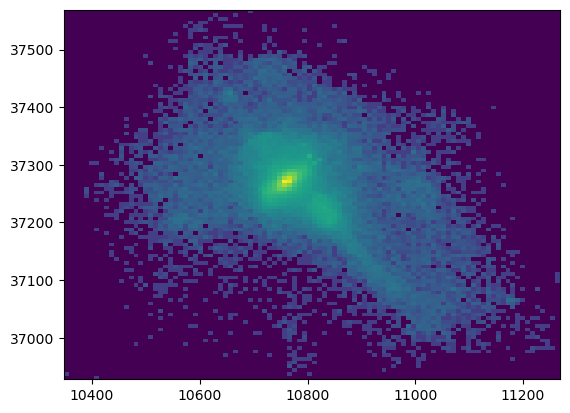

In [14]:
### Plot SubFind that we are interested in ###

halo_ID = 172650
stars = il.snapshot.loadSubhalo(basePath,snap,halo_ID,'stars',fields=['Coordinates', 'Masses'])
plt.hist2d(stars['Coordinates'][:,0],stars['Coordinates'][:,1],bins=100,norm=SymLogNorm(1));

In [15]:
tree_STREAMS = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)

In [18]:
(tree_STREAMS['Mass'][0]/0.6674)

1246.3898354388298

In [37]:
tree['SnapNum'][23757]

57

In [4]:
N_subhalo_in_tree = tree['count']
ID_init = tree['SubhaloID'][0]
subfind_ID = tree['SubfindID']

main_ID = tree_main['SubhaloID'] - ID_init
all_ID = tree['SubhaloID'] - ID_init

In [5]:
subfind_to_ID = {subfind_ID[i]: all_ID[i] for i in range(len(subfind_ID))}

In [6]:
tree['DescendantID'][len(main_ID):] - ID_init

array([92, 98, 99, ...,  0,  0,  0])

In [7]:
descendent_main = tree['DescendantID'].copy() - ID_init
descendent_main[:len(main_ID)] = -1
arg_before_main = np.where( (0 <= descendent_main) & (descendent_main <= main_ID[-1]))[0]

In [8]:
stars_subfindID = np.loadtxt(f'progenitorID_subhalo{halo_ID}.txt', dtype=int)

In [9]:
stars_ID = np.zeros_like(stars_subfindID)
for index, i in enumerate(stars_subfindID):
    stars_ID[index] = subfind_to_ID[i]

In [10]:
next_main = all_ID[arg_before_main]
next_main

array([   98,   101,   104, ..., 78368, 78369, 78370])

In [11]:
stars_ID_before_main = np.zeros_like(stars_ID)
for index, i in enumerate(next_main[:-1]):
    mask_bot = next_main[index] <= stars_ID 
    mask_top = stars_ID < next_main[index+1]
    # print(next_main[index], next_main[index+1])
    mask = mask_bot * mask_top
    stars_ID_before_main[mask] = next_main[index]

In [12]:
subhalo_masses = tree['Mass']
stars_ID_before_main_mass = np.zeros_like(stars_ID_before_main, dtype=np.float32)
for index, i in enumerate(stars_ID_before_main):
    stars_ID_before_main_mass[index] = subhalo_masses[i]

In [13]:
mass_to_use = np.unique(stars_ID_before_main_mass)[-20:][::-1]

In [14]:
dict_mass = dict(zip(mass_to_use,np.arange(1,len(mass_to_use)+1,1)))

In [15]:
stars_ID_before_main_mass

array([ 954.43176,  954.43176,  954.43176, ..., 1581.6897 , 1581.6897 ,
       1581.6897 ], dtype=float32)

In [16]:
result_array = np.array([dict_mass[i] if i in mass_to_use else -1 for index, i in enumerate(stars_ID_before_main_mass)])

In [17]:
fields = ['Coordinates','Masses','ParticleIDs','GFM_StellarFormationTime']
stars  = il.snapshot.loadSubhalo(basePath,snap, halo_ID, 'stars', fields=fields)

In [18]:
stars_ID_before_main_mass.shape

(321798,)

/tmp/ipykernel_2551/744146028.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab20 = plt.cm.get_cmap('tab20', 20).colors
/tmp/ipykernel_2551/744146028.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_use,Y_use,s=0.5, alpha=0.3, label=f'ID={stars_ID_before_main[arg_use][0]}', c=tab20[index])


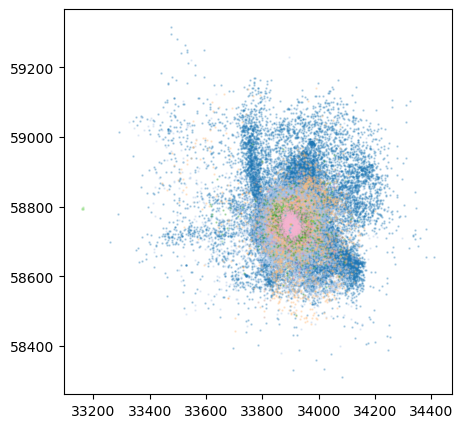

In [19]:
X = stars['Coordinates'][:,1]
Y = stars['Coordinates'][:,2]

tab20 = plt.cm.get_cmap('tab20', 20).colors
plt.figure(figsize=(5,5))
for index, i in enumerate(dict_mass.values()):
    # plt.subplot(5,4,index+1)
    arg_use = np.where(result_array == i)
    X_use = X[arg_use]
    Y_use = Y[arg_use]
    plt.scatter(X_use,Y_use,s=0.5, alpha=0.3, label=f'ID={stars_ID_before_main[arg_use][0]}', c=tab20[index])
    # plt.title(f'ID={stars_ID_before_main[arg_use][0]} - M={stars_ID_before_main_mass[arg_use][0]:.1f}')
    # plt.xlim([33100,34500])
    # plt.ylim([58300,59300])
    # plt.xticks([])
    # plt.yticks([])
# plt.legend(loc='best')

array([239993, 239262, 235073, 235013, 232232, 231094, 229307, 228608,
       227401, 224702, 232166, 229192, 226434, 227345, 224483, 225395,
       220668, 218286, 216955, 213142, 211147, 204849, 201938, 198458,
       194187, 190626, 213781, 211211, 208536, 206265, 203693, 198948,
       192123, 186252, 182347, 175210, 169305, 163781, 157819, 148548,
       141313, 131755, 124423, 119265, 116328, 112065, 108487, 105070,
       102597,  95777,  92129,  88736,  86408,  82332,  77252,  75046,
        68602,  66428, 101492,  94410,  91875,  85553,  80403,  75271,
        79135,  74512,  69290,  62307,  65802,  57484,  52234,  47100,
        46375,  41528,  58035,  49854,  41672,  35210,  32468,  28454,
        22857,  19895,  22570,  19120,  18677,  14823,  13614,  18366,
        29562,  94476,  73318,  69678,  98829, 163494, 467009, 428336,
       190349, 415763], dtype=int32)

 25%|██▌       | 25/100 [00:13<00:40,  1.85it/s]


ValueError: num must be an integer with 1 <= num <= 25, not 26

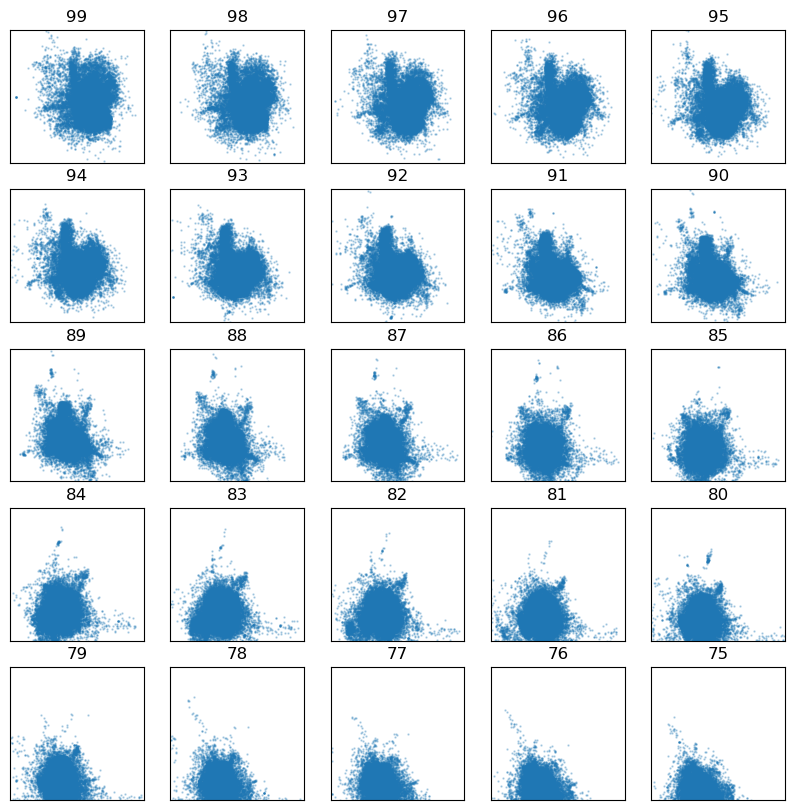

In [30]:
### Plot the main progenitor at very snapshot ###

snapshots = range(99, -1, -1)
main_SubfindID = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True, fields=['SubfindID'])
plt.figure(figsize=(10,10))
for index, i in enumerate(tqdm(snapshots)):
    stars_coord  = il.snapshot.loadSubhalo(basePath,i, main_SubfindID[index], 'stars', fields=['Coordinates'])
    plt.subplot(5,5,index+1)
    X = stars_coord[:,1]
    Y = stars_coord[:,2]
    plt.scatter(X,Y,s=0.5, alpha=0.3)#, c=tab20[index])
    plt.title(f'{i}')
    # plt.title(f'ID={stars_ID_before_main[arg_use][0]} - M={stars_ID_before_main_mass[arg_use][0]:.1f}')
    plt.xlim([33100,34500])
    plt.ylim([58300,59300])
    plt.xticks([])
    plt.yticks([])
# plt.legend(loc='best')

In [76]:
subhalosID = tree['SubfindID']
subhalosSnap  = tree['SnapNum'] 

In [77]:
fields = ['Coordinates','Masses','ParticleIDs','GFM_StellarFormationTime']
stars  = il.snapshot.loadSubhalo(basePath,snap, halo_ID, 'stars', fields=fields)
# stars = il.snapshot.loadSubset(basePath,snap,'stars',fields=fields)

In [19]:
starsID = stars['ParticleIDs']
starsZ  = stars['GFM_StellarFormationTime']**-1 - 1
idx_remove   = np.where(starsZ < 0)
real_starsZ  = np.delete(starsZ,idx_remove)
real_starsId = np.delete(starsID,idx_remove)

In [23]:
redshifts = np.zeros(100)
numsnap = np.arange(0,99 + 1,1)
for i in range(len (numsnap)):
    header = il.groupcat.loadHeader(basePath, numsnap[i])
    redshifts[i] = header[ 'Redshift']
redshifts[-1] = 0

In [27]:
difference = real_starsZ[:,None] - redshifts
difference[difference < 0] = abs(difference.max()) + 1
starsSnap = np.argmin(difference, axis=1)
snap_to_look = np.unique(starsSnap)

In [192]:
progenitorID = np.zeros(stars['count']) - 1

# # Iterate on the snapshots
for s in tqdm(numsnap, leave=True):

    # Iterate on the subhalos in that snapshot ONLY
    idx_subhalos  = np.where(subhalosSnap == s)[0]
    keep_subhalos = subhalosID[idx_subhalos]

    for i in keep_subhalos:

        # Load ID of stars in the subhalo
        subhalos_starsID = il.snapshot.loadSubhalo(basePath,s, i, 'stars', fields=['ParticleIDs'])

        not_already_IDed = np.where(progenitorID == -1)[0]
        stars_in = np.isin(starsID[not_already_IDed], subhalos_starsID)

        indices = not_already_IDed[stars_in]
        progenitorID[indices] = i


100%|██████████| 100/100 [1:01:39<00:00, 36.99s/it]


In [193]:
np.savetxt(f'progenitorID_subhalo{halo_ID}.txt', progenitorID, fmt='%d')

In [79]:
starsID = np.loadtxt(f'progenitorID_subhalo{halo_ID}.txt', dtype=int)

In [228]:
import matplotlib.colors as mcolors
def dominant_progenitor_histogram(X, Y, P, bins=100):
    """
    Compute the dominant progenitor for each bin in a 2D histogram based on coordinates X, Y and progenitors P.
    
    Parameters:
    - X, Y, P: arrays of shape N indicating the X and Y coordinates and progenitor IDs of the stars.
    - bins: number of bins or a sequence defining the bin edges
    
    Returns:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    
    # Create a 2D histogram grid
    H, xedges, yedges = np.histogram2d(X, Y, bins=bins)
    
    # For each bin in the grid, determine the dominant progenitor
    dominant_progenitor = np.zeros(H.shape, dtype=int)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            mask = (X >= xedges[i]) & (X < xedges[i+1]) & (Y >= yedges[j]) & (Y < yedges[j+1])
            unique, counts = np.unique(P[mask], return_counts=True)
            if len(unique) > 0:
                dominant_progenitor[i, j] = unique[np.argmax(counts)]

    # Define a colormap to color each progenitor differently
    colors = list(mcolors.TABLEAU_COLORS.values())
    cmap = mcolors.ListedColormap(colors[:len(np.unique(P))])
    
    return xedges, yedges, dominant_progenitor, cmap

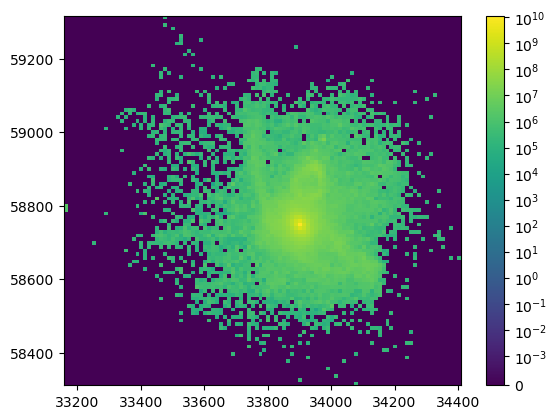

In [80]:
X = stars['Coordinates'][:,1]
Y = stars['Coordinates'][:,2]
plt.hist2d(X, Y, weights=starsID, bins=100,norm=SymLogNorm(0.001)); #, weights=a, bins=100);
plt.colorbar()

In [109]:
from scipy.stats import mode

H, xedge, yedge = np.histogram2d(X, Y, bins=100)

xedge_indice = np.digitize(X, xedge)
yedge_indice = np.digitize(Y, yedge)

mode_array = np.zeros((len(xedge)-1, len(yedge)-1))
for i in range(len(xedge)-1):
    for j in range(len(yedge)-1):
        mask = (xedge_indice == i) & (yedge_indice == j)
        if np.any(mask):
            mode_array[i, j] = mode(starsID[mask]).mode#[0]

In [103]:
np.unique(result_array).shape

(21,)

In [113]:
H, xedge, yedge = np.histogram2d(X, Y, bins=100)

xedge_indice = np.digitize(X, xedge)
yedge_indice = np.digitize(Y, yedge)

mode_array = np.zeros((len(xedge)-1, len(yedge)-1))
for i in range(len(xedge)-1):
    for j in range(len(yedge)-1):
        mask = (xedge_indice == i) & (yedge_indice == j)
        if np.any(mask):
            mode_array[i, j] = mode(result_array[mask]+1).mode#[0]

/tmp/ipykernel_2274/2235898552.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(mode_array), cmap='tab20')


Text(0, 0.5, 'Y')

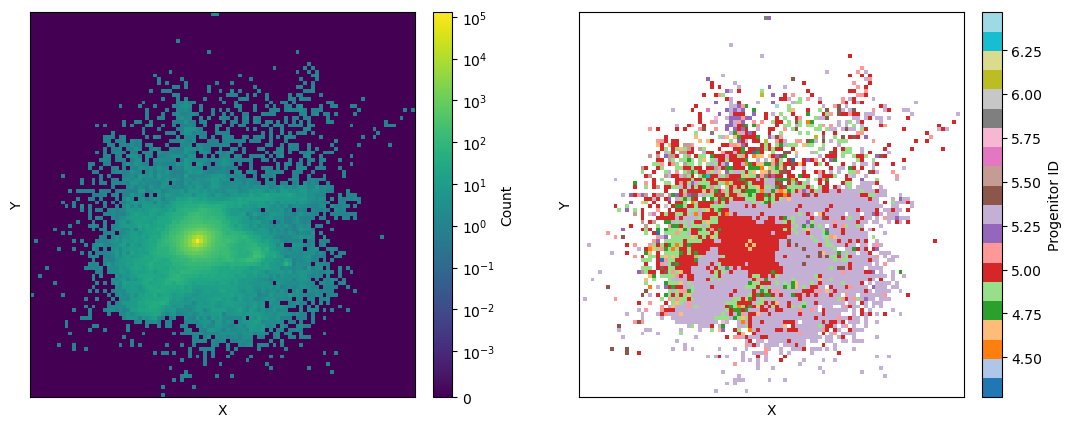

In [110]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
a = np.histogram2d(X, Y, bins=100)#, norm=SymLogNorm(0.001)); #, weights=a, bins=100);
plt.imshow(a[0], norm=SymLogNorm(0.001))
plt.xticks([])
plt.yticks([])
plt.xlabel('X')
plt.ylabel('Y')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Count')
plt.subplot(1,2,2)
plt.imshow(np.log10(mode_array), cmap='tab20')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Progenitor ID')
plt.xlabel('X')
plt.ylabel('Y')

In [131]:
np.unique(mode_array)
### UNIQUE COLORS FOR EVERY VALUE OF MODE_ARRAY ###
import matplotlib.colors as mcolors
color_list = list(mcolors.CSS4_COLORS.keys())
to_remove = ['black', 'white', 'snow', 'whitesmoke', 'seashell', 'ghostwhite', 'mintcream']
color_list = [s for s in color_list if s not in to_remove]
color_list = ['white', 'black']


In [139]:
n_colors = len(color_list)
step = np.round(n_colors / len(np.unique(mode_array)))
color_use =  np.array(color_list)[np.arange(0, n_colors, step).astype(int)]
color_final = ['white', 'black'] + list(color_use[:(len(np.unique(mode_array))-1)])
N = range(len(np.unique(mode_array)))
color_final = plt.cm.get_cmap(color_final, N)

/tmp/ipykernel_2003/3914235126.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_final = plt.cm.get_cmap(color_final, N)


ValueError: ['white', 'black', 'aliceblue', 'beige', 'brown', 'coral', 'darkblue', 'darkgrey', 'darkorchid', 'darkslategray', 'deepskyblue', 'floralwhite', 'goldenrod', 'honeydew', 'khaki', 'lightblue', 'lightgreen', 'lightskyblue', 'lime', 'mediumaquamarine', 'mediumslateblue', 'mistyrose', 'olive', 'palegoldenrod', 'peachpuff', 'purple', 'saddlebrown'] is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

In [138]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(color_final())

TypeError: 'list' object is not callable

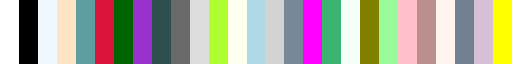

In [134]:
cmap

In [132]:
final_dict = dict(zip(np.unique(mode_array), np.arange(1,len(np.unique(mode_array))+1,1)))
final_results = np.zeros_like(mode_array)
for index, i in enumerate(mode_array):
    for jndex, j in enumerate(i):
        if j in final_dict.keys():
            final_results[index,jndex] = final_dict[j]

Text(0, 0.5, 'Y')

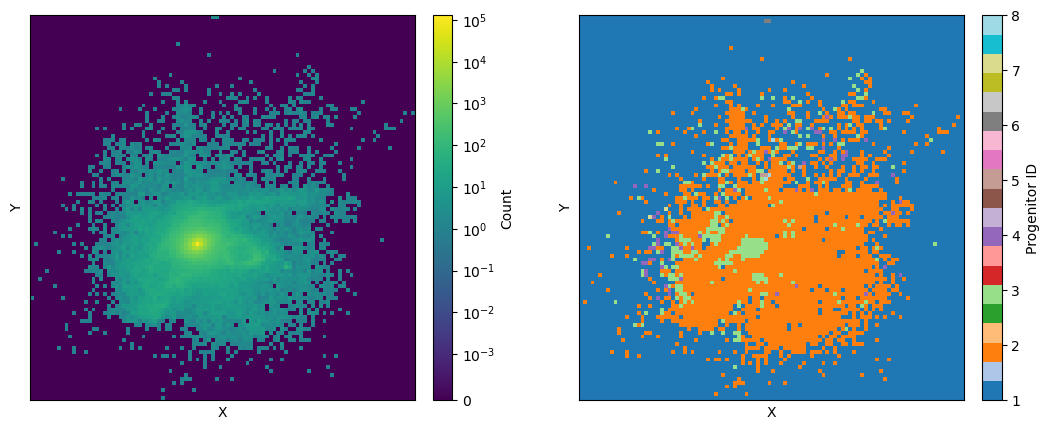

In [135]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
a = np.histogram2d(X, Y, bins=100)#, norm=SymLogNorm(0.001)); #, weights=a, bins=100);
plt.imshow(a[0], norm=SymLogNorm(0.001))
plt.xticks([])
plt.yticks([])
plt.xlabel('X')
plt.ylabel('Y')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Count')
plt.subplot(1,2,2)
plt.imshow(final_results, cmap='tab20')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('Progenitor ID')
plt.xlabel('X')
plt.ylabel('Y')

/tmp/ipykernel_1617/1999081315.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(mode_array), cmap='tab20')


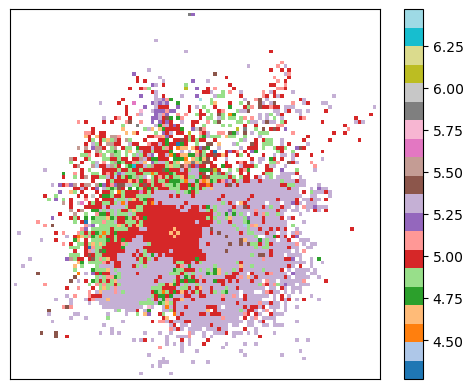

In [97]:
# plt.subplot(1, 2, 1) 
# plt.hist2d(X, Y, weights=starsID, bins=100,norm=SymLogNorm(0.001)); #, weights=a, bins=100);
# plt.colorbar()
# plt.subplot(1, 2, 2)
plt.imshow(np.log10(mode_array), cmap='tab20')
plt.xticks([])
plt.yticks([])
plt.colorbar()

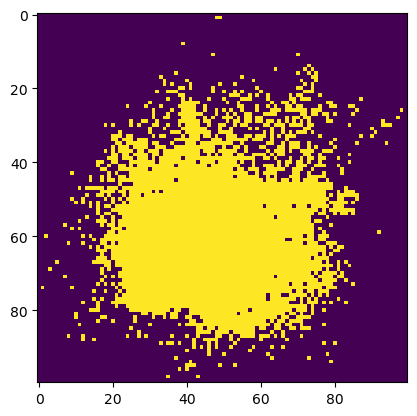

In [42]:
import matplotlib.colors as mcolors

# Find unique values in the mode_array
unique_values = np.unique(mode_array)

# Create a colormap that maps each unique value to a color
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_values)))
colormap = mcolors.ListedColormap(colors)

# Create a norm object to map data values to the interval [0,1]
norm = mcolors.BoundaryNorm(np.arange(len(unique_values)+1)-0.5, len(unique_values))

# Plot the 2D array of modes
plt.imshow(mode_array, cmap=colormap, norm=norm, interpolation='nearest')

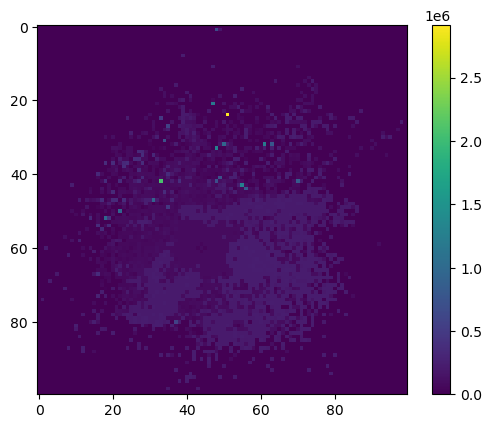

In [39]:
plt.imshow(mode_array, cmap='viridis', interpolation='nearest')
plt.colorbar()

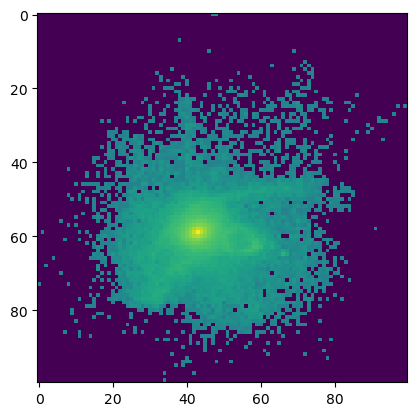

In [16]:
plt.imshow(H, norm=SymLogNorm(0.001))

In [123]:
not_already_IDed.sum()+4776

321798

In [115]:
(starsSnap == s).sum()

914

In [116]:
np.where(progenitorID != -1)[0].shape

(4776,)

array([False, False, False, ..., False, False, False])

In [7]:
def inverseMapPartIndicesToSubhaloIDs(indsType, SubhaloLenType, SnapOffsetsSubhalo, debug=False, flagFuzz=True):
    """ For a particle type ptName and snapshot indices for that type indsType, compute the
        subhalo ID to which each particle index belongs. 
        If flagFuzz is True (default), particles in FoF fuzz are marked as outside any subhalo,
        otherwise they are attributed to the closest (prior) subhalo.
    """
    gcLenType = SubhaloLenType[:,4]
    gcOffsetsType = SnapOffsetsSubhalo#[:-1]

    # val gives the indices of gcOffsetsType such that, if each indsType was inserted
    # into gcOffsetsType just -before- its index, the order of gcOffsetsType is unchanged
    # note 1: (gcOffsetsType-1) so that the case of the particle index equaling the
    # subhalo offset (i.e. first particle) works correctly
    # note 2: np.ss()-1 to shift to the previous subhalo, since we want to know the
    # subhalo offset index -after- which the particle should be inserted
    val = np.searchsorted( gcOffsetsType - 1, indsType ) - 1
    val = val.astype('int32')

    # search and flag all matches where the indices exceed the length of the
    # subhalo they have been assigned to, e.g. either in fof fuzz, in subhalos with
    # no particles of this type, or not in any subhalo at the end of the file
    if flagFuzz:
        gcOffsetsMax = gcOffsetsType + gcLenType - 1
        ww = np.where( indsType > gcOffsetsMax[val] )[0]

        if len(ww):
            val[ww] = -1

    if debug:
        # for all inds we identified in subhalos, verify parents directly
        for i in range(len(indsType)):
            if val[i] < 0:
                continue
            assert indsType[i] >= gcOffsetsType[val[i]]
            if flagFuzz:
                assert indsType[i] < gcOffsetsType[val[i]]+gcLenType[val[i]]
                assert gcLenType[val[i]] != 0

    return val

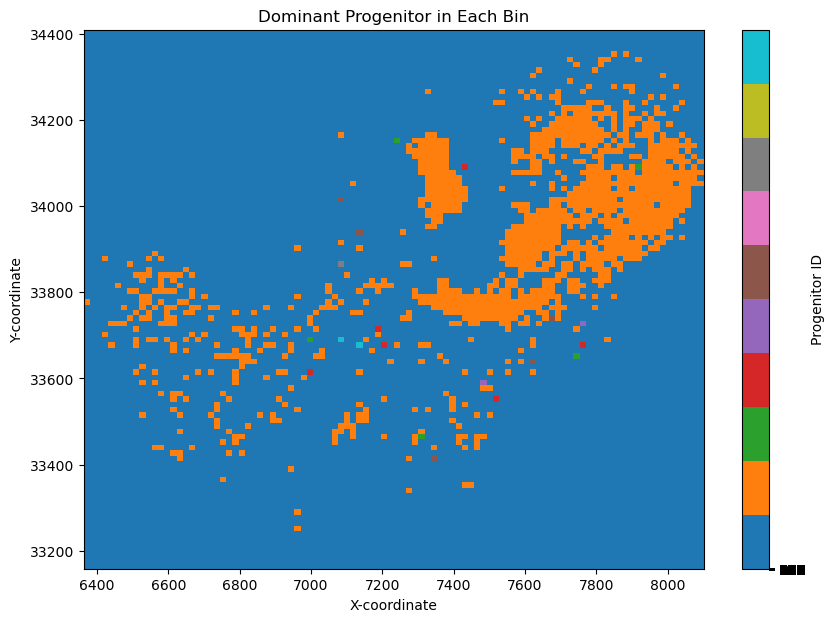

In [230]:
proj_1 = 0
proj_2 = 1
xedge,yedge,dominant,colmap = dominant_progenitor_histogram(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],a)

def plot_dominant_progenitor(xedges, yedges, dominant_progenitor, cmap):
    """
    Plot the dominant progenitor for each bin in a 2D histogram.
    
    Parameters:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(xedges, yedges, dominant_progenitor.T, cmap=cmap)
    plt.colorbar(ticks=np.arange(len(np.unique(dominant_progenitor))), label='Progenitor ID')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Dominant Progenitor in Each Bin')
    plt.show()

# Plotting using the function
plot_dominant_progenitor(xedge, yedge, dominant, colmap)

In [54]:
subhaloIDstars = np.zeros(len(real_starsId)) 
#np.loadtxt('SubhaloID_stars.txt').astype(int)
for i in tqdm(snap_to_look[31:], leave=True):
    all_starsID = il.snapshot.loadSubset(basePath,i,'stars',fields=['ParticleIDs'])

    stars_in = np.isin(all_starsID,real_starsId[starsSnap == i])
    indices  = np.arange(0,len(stars_in),1)
    stars_idx_snap = indices[stars_in] 

    ptType = 4 
    with h5py.File(il.groupcat.offsetPath(basePath,i),'r') as f:
        gcOffsetsType   = f['Subhalo/SnapByType'][:,ptType]

    gcLenType = il.groupcat.loadSubhalos(basePath, i, 'SubhaloLenType') 

    subhaloIDstars_snap = inverseMapPartIndicesToSubhaloIDs(stars_idx_snap,gcLenType,gcOffsetsType)

    subhaloIDstars[starsSnap == i] = subhaloIDstars_snap

    np.savetxt('SubhaloID_stars.txt', subhaloIDstars.astype(int))

    

  1%|▏         | 1/67 [02:11<2:24:53, 131.72s/it]

: 

: 

In [36]:
indices[stars_in] == indices[starsSnap == i]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 143951082 but corresponding boolean dimension is 321761

In [37]:
stars_in.shape

(143951082,)

In [30]:
a = np.isin(real_starsId[starsSnap == i],all_starsID)

array([ True,  True,  True, ...,  True,  True,  True])

In [34]:
starsSnap == i

array([False, False, False, ..., False, False, False])

In [11]:
snap_to_look[31:]

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [12]:
all_starsID = il.snapshot.loadSubset(basePath,34,'stars',fields=['ParticleIDs'])


In [13]:
stars_in = np.isin(all_starsID,real_starsId)
indices  = np.arange(0,len(stars_in),1)
stars_idx_snap = indices[stars_in]

In [14]:
ptType = 4
with h5py.File(il.groupcat.offsetPath(basePath,34),'r') as f:
    gcOffsetsType   = f['Subhalo/SnapByType'][:,ptType]

In [15]:
gcLenType = il.groupcat.loadSubhalos(basePath, 34, 'SubhaloLenType') 

In [17]:
a = np.loadtxt('SubhaloID_stars.txt').astype(int)

a[np.isin(real_starsId,all_starsID)]

array([69290,     0, 69290, ...,    -1,    -1,    -1])

In [ ]:
'''
0-31 : loaded
31-
'''

In [ ]:
import matplotlib.colors as mcolors
def dominant_progenitor_histogram(X, Y, P, bins=100):
    """
    Compute the dominant progenitor for each bin in a 2D histogram based on coordinates X, Y and progenitors P.
    
    Parameters:
    - X, Y, P: arrays of shape N indicating the X and Y coordinates and progenitor IDs of the stars.
    - bins: number of bins or a sequence defining the bin edges
    
    Returns:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    
    # Create a 2D histogram grid
    H, xedges, yedges = np.histogram2d(X, Y, bins=bins)
    
    # For each bin in the grid, determine the dominant progenitor
    dominant_progenitor = np.zeros(H.shape, dtype=int)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            mask = (X >= xedges[i]) & (X < xedges[i+1]) & (Y >= yedges[j]) & (Y < yedges[j+1])
            unique, counts = np.unique(P[mask], return_counts=True)
            if len(unique) > 0:
                dominant_progenitor[i, j] = unique[np.argmax(counts)]

    # Define a colormap to color each progenitor differently
    colors = list(mcolors.TABLEAU_COLORS.values())
    cmap = mcolors.ListedColormap(colors[:len(np.unique(P))])
    
    return xedges, yedges, dominant_progenitor, cmap

In [ ]:
proj_1 = 0
proj_2 = 1
xedge,yedge,dominant,colmap = dominant_progenitor_histogram(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],subhaloIDstars)

def plot_dominant_progenitor(xedges, yedges, dominant_progenitor, cmap):
    """
    Plot the dominant progenitor for each bin in a 2D histogram.
    
    Parameters:
    - xedges, yedges: bin edges in the x and y directions
    - dominant_progenitor: 2D array indicating the dominant progenitor in each bin
    - cmap: colormap used for different progenitors
    """
    plt.figure(figsize=(10, 7))
    plt.pcolormesh(xedges, yedges, dominant_progenitor.T, cmap=cmap)
    plt.colorbar(ticks=np.arange(len(np.unique(dominant_progenitor))), label='Progenitor ID')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Dominant Progenitor in Each Bin')
    plt.show()

# Plotting using the function
plot_dominant_progenitor(xedge, yedge, dominant, colmap)

In [ ]:
proj_1 = 1
proj_2 = 2
xedge,yedge,dominant,colmap = dominant_progenitor_histogram(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],subhaloIDstars)

plot_dominant_progenitor(xedge, yedge, dominant, colmap)

In [42]:
snap0 = 99
snap1 = 90
i = 239993
tree = il.sublink.loadTree(basePath,snap0,i,fields=['SubfindID','SnapNum'],onlyMPB=True)

TreeIndex_at_snap1 = np.where(tree['SnapNum'] == snap1)
assert len(TreeIndex_at_snap1[0]) == 1

SubfindID_at_snap1 = tree['SubfindID'][TreeIndex_at_snap1]

particle_data = il.snapshot.loadSubhalo(basePath,snap1,SubfindID_at_snap1,'dm','Coordinates')

IndexError: index 1 is out of bounds for axis 0 with size 1

In [43]:
tree

{'count': 98,
 'SubfindID': array([239993, 239262, 235073, 235013, 232232, 231094, 229307, 228608,
        227401, 224702, 232166, 229192, 226434, 227345, 224483, 225395,
        220668, 218286, 216955, 213142, 211147, 204849, 201938, 198458,
        194187, 190626, 213781, 211211, 208536, 206265, 203693, 198948,
        192123, 186252, 182347, 175210, 169305, 163781, 157819, 148548,
        141313, 131755, 124423, 119265, 116328, 112065, 108487, 105070,
        102597,  95777,  92129,  88736,  86408,  82332,  77252,  75046,
         68602,  66428, 101492,  94410,  91875,  85553,  80403,  75271,
         79135,  74512,  69290,  62307,  65802,  57484,  52234,  47100,
         46375,  41528,  58035,  49854,  41672,  35210,  32468,  28454,
         22857,  19895,  22570,  19120,  18677,  14823,  13614,  18366,
         29562,  94476,  73318,  69678,  98829, 163494, 467009, 428336,
        190349, 415763], dtype=int32),
 'SnapNum': array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87,

In [37]:
fields = ['SubhaloID']

subhalos_before = il.groupcat.loadSubhalos(basePath,90)#,fields=fields)

In [39]:
subhalos_before['count']

4459038

In [19]:
def inverseMapPartIndicesToSubhaloIDs(sP, indsType, ptName, debug=False, flagFuzz=True, SubhaloLenType, SnapOffsetsSubhalo):
    """ For a particle type ptName and snapshot indices for that type indsType, compute the
        subhalo ID to which each particle index belongs. 
        If flagFuzz is True (default), particles in FoF fuzz are marked as outside any subhalo,
        otherwise they are attributed to the closest (prior) subhalo.
    """
    gcLenType = SubhaloLenType[:,sP.ptNum(ptName)]
    gcOffsetsType = SnapOffsetsSubhalo[:,sP.ptNum(ptName)][:-1]

    # val gives the indices of gcOffsetsType such that, if each indsType was inserted
    # into gcOffsetsType just -before- its index, the order of gcOffsetsType is unchanged
    # note 1: (gcOffsetsType-1) so that the case of the particle index equaling the
    # subhalo offset (i.e. first particle) works correctly
    # note 2: np.ss()-1 to shift to the previous subhalo, since we want to know the
    # subhalo offset index -after- which the particle should be inserted
    val = np.searchsorted( gcOffsetsType - 1, indsType ) - 1
    val = val.astype('int32')

    # search and flag all matches where the indices exceed the length of the
    # subhalo they have been assigned to, e.g. either in fof fuzz, in subhalos with
    # no particles of this type, or not in any subhalo at the end of the file
    if flagFuzz:
        gcOffsetsMax = gcOffsetsType + gcLenType - 1
        ww = np.where( indsType > gcOffsetsMax[val] )[0]

        if len(ww):
            val[ww] = -1

    if debug:
        # for all inds we identified in subhalos, verify parents directly
        for i in range(len(indsType)):
            if val[i] < 0:
                continue
            assert indsType[i] >= gcOffsetsType[val[i]]
            if flagFuzz:
                assert indsType[i] < gcOffsetsType[val[i]]+gcLenType[val[i]]
                assert gcLenType[val[i]] != 0

    return val

SyntaxError: non-default argument follows default argument (3111884120.py, line 1)

In [11]:
np.floor(z)

array([3., 4., 3., ..., 3., 4., 3.], dtype=float32)

In [4]:
tracers.keys()

dict_keys(['count'])

In [5]:
tracers['count']

0

In [19]:
fields = ['Coordinates', 'Masses','ParticleIDs']
halo_ID = 239993
tree = il.sublink.loadTree(basePath,snap,halo_ID,onlyMPB=True)
subfind = tree['SubfindID']
idx_1 = 0
idx_2 = 15
idx_3 = 20
stars   = il.snapshot.loadSubhalo(basePath,int(99-idx_1), subfind[idx_1], 'stars', fields=fields)
stars_2 = il.snapshot.loadSubhalo(basePath,int(99-idx_2), subfind[idx_2], 'stars', fields=fields)
stars_3 = il.snapshot.loadSubhalo(basePath,int(99-idx_3), subfind[idx_3], 'stars', fields=fields)

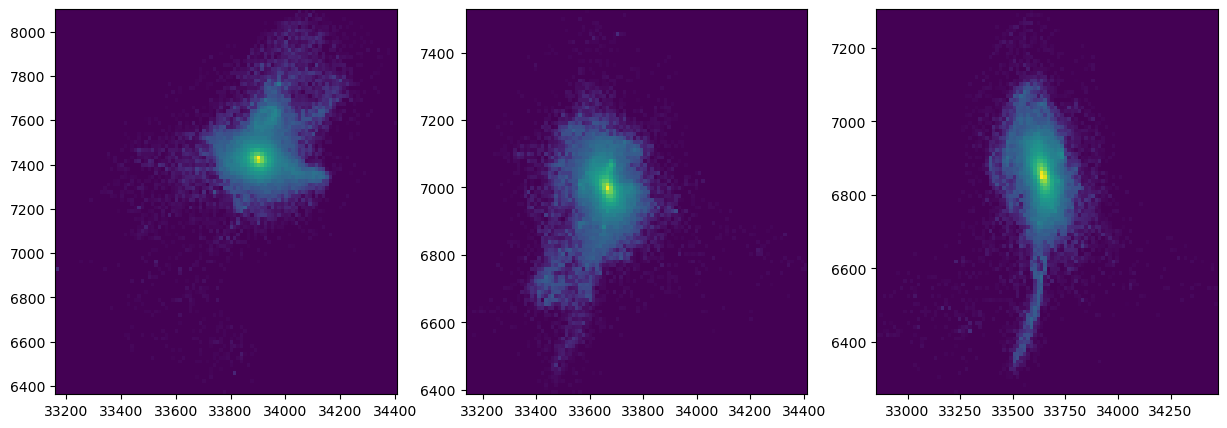

In [21]:
proj_1 = 1
proj_2 = 0
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist2d(stars['Coordinates'][:,proj_1],stars['Coordinates'][:,proj_2],weights=stars['Masses'],bins=100,norm=SymLogNorm(0.001));
plt.subplot(1,3,2)
plt.hist2d(stars_2['Coordinates'][:,proj_1],stars_2['Coordinates'][:,proj_2],weights=stars_2['Masses'],bins=100,norm=SymLogNorm(0.001));
plt.subplot(1,3,3)
plt.hist2d(stars_3['Coordinates'][:,proj_1],stars_3['Coordinates'][:,proj_2],weights=stars_3['Masses'],bins=100,norm=SymLogNorm(0.001));


In [24]:
stars_id_99 = stars['ParticleIDs']
stars_id_98 = stars_2['ParticleIDs']
stars_id_84 = stars_3['ParticleIDs']

idx_not_both = np.isin(stars_id_99,stars_id_98, invert=True)
idx_not_both.sum()

12823

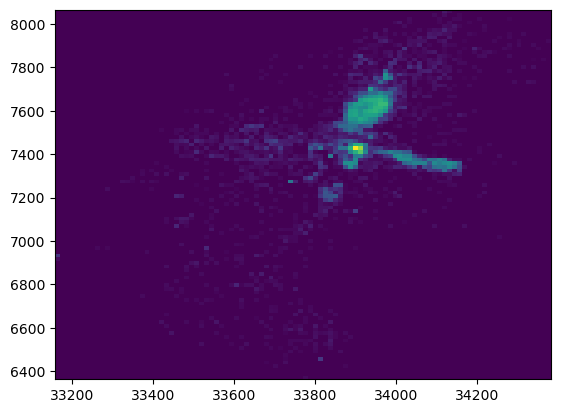

In [35]:
plt.hist2d(stars['Coordinates'][idx_not_both,proj_1],stars['Coordinates'][idx_not_both,proj_2],weights=stars['Masses'][idx_not_both],bins=100,norm=SymLogNorm(0.001));

In [18]:
plot_stars = stars_3
stars_mass = plot_stars['Masses']
stars_mass_keep = plot_stars['Masses'][idx_not_both]
stars_y = plot_stars['Coordinates'][:,1]
stars_z = plot_stars['Coordinates'][:,2]
stars_y_keep = plot_stars['Coordinates'][idx_not_both,1]
stars_z_keep = plot_stars['Coordinates'][idx_not_both,2]
plt.subplot(1,2,1)
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.subplot(1,2,2)
plt.hist2d(stars_y_keep,stars_z_keep,bins=10);

IndexError: boolean index did not match indexed array along dimension 0; dimension is 301165 but corresponding boolean dimension is 321798

In [80]:
center_x = np.mean(stars['Coordinates'][:,0])
center_y = np.mean(stars['Coordinates'][:,1])
center_z = np.mean(stars['Coordinates'][:,2])

stars_x = stars['Coordinates'][:,0] #- center_x
stars_y = stars['Coordinates'][:,1] #- center_y
stars_z = stars['Coordinates'][:,2] #- center_z

# birth_x = stars['BirthPos'][:,0] #- center_x
# birth_y = stars['BirthPos'][:,1] #- center_y
# birth_z = stars['BirthPos'][:,2] #- center_z

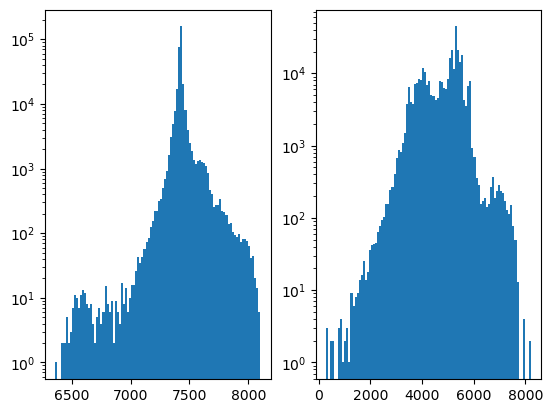

In [ ]:
plt.subplot(1,2,1)
plt.hist(stars_x,bins=100);
plt.yscale('log')
plt.subplot(1,2,2)
plt.yscale('log')
plt.hist(birth_x,bins=100);

In [78]:
r = np.sqrt(stars_x**2+stars_y**2+stars_z**2)
r_birth = np.sqrt(birth_x**2+birth_y**2+birth_z**2)

NameError: name 'birth_x' is not defined

NameError: name 'r_birth' is not defined

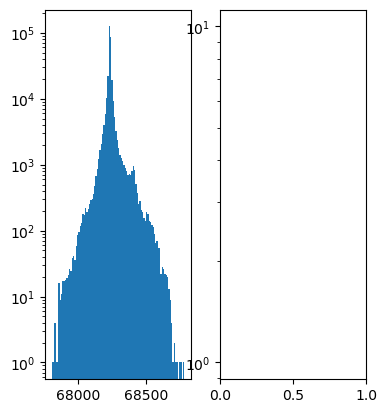

In [79]:
plt.subplot(1,3,1)
plt.hist(r,bins=100);
plt.yscale('log')
plt.subplot(1,3,2)
plt.yscale('log')
plt.hist(r_birth,bins=100);
plt.subplot(1,3,3)
plt.yscale('log')
plt.hist(abs(r-r_birth),bins=100);

In [172]:
idx_small = abs(r-r_birth) < 4000
idx_big   = 3000 < abs(r-r_birth)
idx_exsitu = idx_small*idx_big

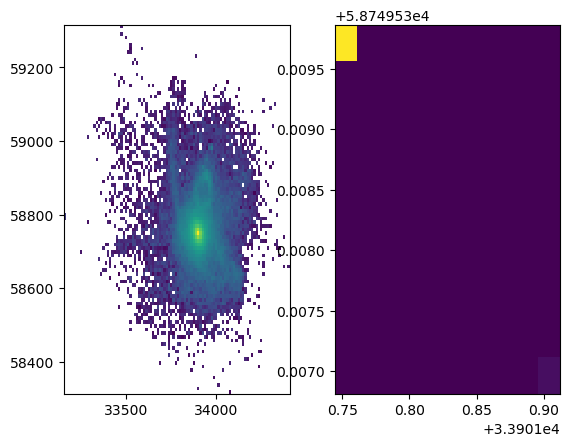

In [92]:
stars_mass = stars['Masses']
plt.subplot(1,2,1)
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.subplot(1,2,2)
plt.hist2d(stars_y[idx_not_both],stars_z[idx_not_both],weights=stars_mass[idx_not_both],bins=100);

In [44]:
tree = il.sublink.loadTree(basePath,snap_1,haloID,onlyMPB=True)#,fields='all',onlyMPB=True)

In [45]:
tree.keys()

dict_keys(['count', 'DescendantID', 'FirstProgenitorID', 'FirstSubhaloInFOFGroupID', 'GroupBHMass', 'GroupBHMdot', 'GroupCM', 'GroupFirstSub', 'GroupGasMetalFractions', 'GroupGasMetallicity', 'GroupLen', 'GroupLenType', 'GroupMass', 'GroupMassType', 'GroupNsubs', 'GroupPos', 'GroupSFR', 'GroupStarMetalFractions', 'GroupStarMetallicity', 'GroupVel', 'GroupWindMass', 'Group_M_Crit200', 'Group_M_Crit500', 'Group_M_Mean200', 'Group_M_TopHat200', 'Group_R_Crit200', 'Group_R_Crit500', 'Group_R_Mean200', 'Group_R_TopHat200', 'LastProgenitorID', 'MainLeafProgenitorID', 'Mass', 'MassHistory', 'NextProgenitorID', 'NextSubhaloInFOFGroupID', 'NumParticles', 'RootDescendantID', 'SnapNum', 'SubfindID', 'SubhaloBHMass', 'SubhaloBHMdot', 'SubhaloBfldDisk', 'SubhaloBfldHalo', 'SubhaloCM', 'SubhaloGasMetalFractions', 'SubhaloGasMetalFractionsHalfRad', 'SubhaloGasMetalFractionsMaxRad', 'SubhaloGasMetalFractionsSfr', 'SubhaloGasMetalFractionsSfrWeighted', 'SubhaloGasMetallicity', 'SubhaloGasMetallicityHal

In [57]:
tree['SubfindID']

array([239993, 239262, 235073, 235013, 232232, 231094, 229307, 228608,
       227401, 224702, 232166, 229192, 226434, 227345, 224483, 225395,
       220668, 218286, 216955, 213142, 211147, 204849, 201938, 198458,
       194187, 190626, 213781, 211211, 208536, 206265, 203693, 198948,
       192123, 186252, 182347, 175210, 169305, 163781, 157819, 148548,
       141313, 131755, 124423, 119265, 116328, 112065, 108487, 105070,
       102597,  95777,  92129,  88736,  86408,  82332,  77252,  75046,
        68602,  66428, 101492,  94410,  91875,  85553,  80403,  75271,
        79135,  74512,  69290,  62307,  65802,  57484,  52234,  47100,
        46375,  41528,  58035,  49854,  41672,  35210,  32468,  28454,
        22857,  19895,  22570,  19120,  18677,  14823,  13614,  18366,
        29562,  94476,  73318,  69678,  98829, 163494, 467009, 428336,
       190349, 415763], dtype=int32)

In [46]:
tree['SnapNum']

array([99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83,
       82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66,
       65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49,
       48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32,
       31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15,
       14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2], dtype=int16)

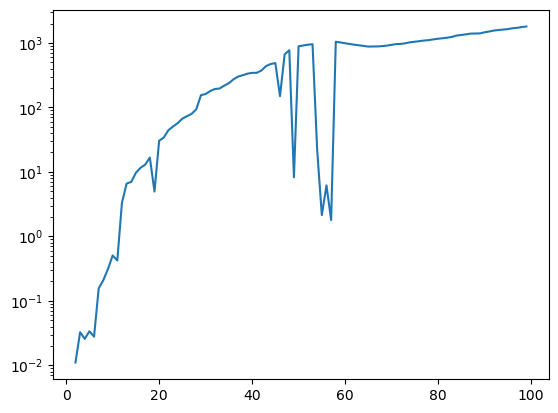

In [47]:
plt.plot(tree['SnapNum'],tree['SubhaloMass'])
plt.yscale('log')

In [51]:
tree['GroupPos'].shape

(78371, 3)

In [52]:
group_mass = tree['GroupMass']
group_x = tree['GroupPos'][:,0]
group_y = tree['GroupPos'][:,1]
group_z = tree['GroupPos'][:,2]

([], [])

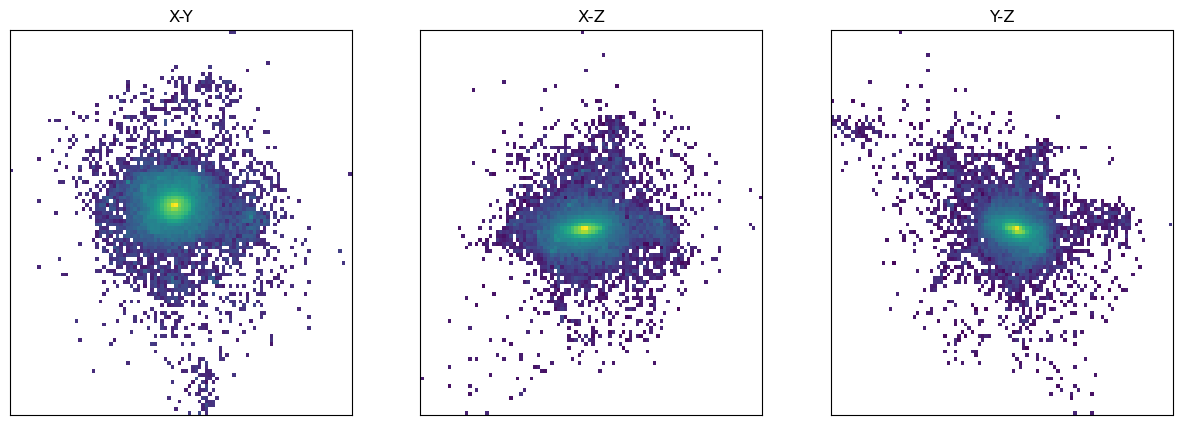

In [18]:
stars_x = stars_99['Coordinates'][:,0]
stars_y = stars_99['Coordinates'][:,1]
stars_z = stars_99['Coordinates'][:,2]
stars_mass = stars_99['Masses']
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('X-Y')
plt.hist2d(stars_x,stars_y,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.title('X-Z')
plt.hist2d(stars_x,stars_z,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.title('Y-Z')
plt.hist2d(stars_y,stars_z,weights=stars_mass,bins=100,norm='log');
plt.xticks([])
plt.yticks([])